# 02 - Baseline Models for Churn Classification

This notebook builds baseline classifiers for customer churn prediction:
- Logistic Regression
- XGBoost
- LightGBM

Features:
- MLflow experiment tracking
- Hyperparameter grid search
- Automated model card generation

## 1. Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ML imports
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve
)
import xgboost as xgb
import lightgbm as lgb

# MLflow
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("Libraries loaded successfully!")
print(f"MLflow version: {mlflow.__version__}")

Libraries loaded successfully!
MLflow version: 3.7.0


## 2. MLflow Configuration

In [2]:
# Configure MLflow
PROJECT_ROOT = Path(".").resolve().parent
MLFLOW_TRACKING_URI = PROJECT_ROOT / "mlruns"
EXPERIMENT_NAME = "churn-classification-baselines"

mlflow.set_tracking_uri(str(MLFLOW_TRACKING_URI))
mlflow.set_experiment(EXPERIMENT_NAME)

print(f"MLflow tracking URI: {MLFLOW_TRACKING_URI}")
print(f"Experiment: {EXPERIMENT_NAME}")

MLflow tracking URI: /home/onlyahad/Desktop/Flagship Project/mlruns
Experiment: churn-classification-baselines


## 3. Data Loading & Feature Engineering

In [3]:
def load_events_data(delta_path: str = None, parquet_path: str = None) -> pd.DataFrame:
    """Load events data from Delta Lake or Parquet."""
    if delta_path:
        try:
            from deltalake import DeltaTable
            dt = DeltaTable(delta_path)
            df = dt.to_pandas()
            print(f"Loaded {len(df):,} rows from Delta: {delta_path}")
            return df
        except Exception as e:
            print(f"Delta loading failed: {e}")
    
    if parquet_path:
        df = pd.read_parquet(parquet_path)
        print(f"Loaded {len(df):,} rows from Parquet: {parquet_path}")
        return df
    
    raise FileNotFoundError("No valid data source")


# Load data
DELTA_PATH = PROJECT_ROOT / "data" / "lake" / "delta" / "events"
PARQUET_PATH = PROJECT_ROOT / "data" / "sample" / "events.parquet"

df = load_events_data(
    delta_path=str(DELTA_PATH) if DELTA_PATH.exists() else None,
    parquet_path=str(PARQUET_PATH)
)

print(f"Dataset shape: {df.shape}")

Loaded 50,000 rows from Parquet: /home/onlyahad/Desktop/Flagship Project/data/sample/events.parquet
Dataset shape: (50000, 8)


In [4]:
# Parse metadata and timestamp
if 'metadata' in df.columns and df['metadata'].dtype == 'object':
    df['metadata'] = df['metadata'].apply(
        lambda x: json.loads(x) if isinstance(x, str) else x
    )

df['channel'] = df['metadata'].apply(lambda x: x.get('channel') if isinstance(x, dict) else None)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['revenue'] = df['price'] * df['quantity']

print("Preprocessing complete!")

Preprocessing complete!


## 4. Churn Label Definition

**Churn Definition**: A user is considered churned if they have no activity in the last 7 days of the dataset timeframe.

In [5]:
def create_churn_labels(df: pd.DataFrame, churn_window_days: int = 7) -> pd.DataFrame:
    """
    Create churn labels based on user activity.
    Handles both multi-transaction users and single-transaction synthetic data.
    
    For real data: Churned = no activity in the last N days of the dataset.
    For synthetic single-transaction data: Creates simulated churn based on
    transaction characteristics (recency + revenue percentile).
    """
    max_date = df['timestamp'].max()
    cutoff_date = max_date - timedelta(days=churn_window_days)
    
    # Split data: training period vs churn evaluation period
    train_data = df[df['timestamp'] < cutoff_date].copy()
    churn_period = df[df['timestamp'] >= cutoff_date].copy()
    
    # Users active in churn period = not churned
    active_users = set(churn_period['user_id'].unique())
    train_users = set(train_data['user_id'].unique())
    
    # Check if we have overlap (real multi-transaction data)
    overlap = train_users & active_users
    use_synthetic_labels = len(overlap) < 0.05 * len(train_users) if len(train_users) > 0 else True
    
    if use_synthetic_labels:
        print("[INFO] Detected single-transaction-per-user data. Using synthetic churn labels.")
        # Use all data for feature engineering when each user has ~1 transaction
        user_features = df.groupby('user_id').agg({
            'id': 'count',
            'revenue': ['sum', 'mean', 'std'],
            'price': ['mean', 'max', 'min'],
            'quantity': ['sum', 'mean'],
            'timestamp': ['min', 'max'],
            'channel': lambda x: x.mode().iloc[0] if len(x) > 0 else 'unknown'
        }).reset_index()
    else:
        # Aggregate user features from training period only
        user_features = train_data.groupby('user_id').agg({
            'id': 'count',
            'revenue': ['sum', 'mean', 'std'],
            'price': ['mean', 'max', 'min'],
            'quantity': ['sum', 'mean'],
            'timestamp': ['min', 'max'],
            'channel': lambda x: x.mode().iloc[0] if len(x) > 0 else 'unknown'
        }).reset_index()
    
    # Flatten column names
    user_features.columns = [
        'user_id', 'transaction_count', 'total_revenue', 'avg_revenue', 'std_revenue',
        'avg_price', 'max_price', 'min_price', 'total_quantity', 'avg_quantity',
        'first_transaction', 'last_transaction', 'primary_channel'
    ]
    
    # Calculate derived features (use max_date as reference for synthetic)
    ref_date = max_date if use_synthetic_labels else cutoff_date
    user_features['days_since_first'] = (
        (ref_date - user_features['first_transaction']).dt.days
    )
    user_features['days_since_last'] = (
        (ref_date - user_features['last_transaction']).dt.days
    )
    user_features['avg_days_between'] = (
        user_features['days_since_first'] / user_features['transaction_count'].clip(lower=1)
    )
    
    # Fill NaN in std_revenue (users with 1 transaction)
    user_features['std_revenue'] = user_features['std_revenue'].fillna(0)
    
    # Create churn label
    if use_synthetic_labels:
        # Synthetic churn: Users with low revenue AND high recency are 'churned'
        # This creates a ~30% churn rate based on bottom revenue quartile + recent inactivity
        revenue_threshold = user_features['total_revenue'].quantile(0.35)
        recency_threshold = user_features['days_since_last'].quantile(0.65)
        
        # Churn if: low revenue OR (medium revenue AND high recency)
        user_features['churned'] = (
            (user_features['total_revenue'] < revenue_threshold) |
            ((user_features['total_revenue'] < user_features['total_revenue'].quantile(0.5)) &
             (user_features['days_since_last'] > recency_threshold))
        ).astype(int)
        
        print(f"[INFO] Synthetic churn rate: {user_features['churned'].mean():.2%}")
    else:
        user_features['churned'] = ~user_features['user_id'].isin(active_users)
        user_features['churned'] = user_features['churned'].astype(int)
    
    # Drop timestamp columns (not needed for modeling)
    user_features = user_features.drop(['first_transaction', 'last_transaction'], axis=1)
    
    return user_features


# Create user-level dataset with churn labels
CHURN_WINDOW = 7
user_df = create_churn_labels(df, churn_window_days=CHURN_WINDOW)

print(f"\nUser-level dataset: {user_df.shape}")
print(f"\nChurn distribution:")
print(user_df['churned'].value_counts(normalize=True).round(3))

[INFO] Detected single-transaction-per-user data. Using synthetic churn labels.


[INFO] Synthetic churn rate: 39.93%

User-level dataset: (50000, 15)

Churn distribution:
churned
0    0.601
1    0.399
Name: proportion, dtype: float64


In [6]:
user_df.head()

,user_id,transaction_count,total_revenue,avg_revenue,std_revenue,avg_price,max_price,min_price,total_quantity,avg_quantity,primary_channel,days_since_first,days_since_last,avg_days_between,churned
0,usr_00022d53-ae9,1,2789.50,2789.50,0.0,398.50,398.50,398.50,7,7.0,pos,22,22,22.0,0
1,usr_00036bdb-255,1,1519.60,1519.60,0.0,189.95,189.95,189.95,8,8.0,pos,24,24,24.0,1
2,usr_0004c03f-f8e,1,3012.92,3012.92,0.0,753.23,753.23,753.23,4,4.0,pos,25,25,25.0,0
3,usr_0005e7ba-25e,1,8088.20,8088.20,0.0,808.82,808.82,808.82,10,10.0,web,2,2,2.0,0
4,usr_00060d5a-02b,1,3329.60,3329.60,0.0,416.20,416.20,416.20,8,8.0,pos,5,5,5.0,0


## 5. Train/Validation Split

In [7]:
# Define features and target
feature_cols = [
    'transaction_count', 'total_revenue', 'avg_revenue', 'std_revenue',
    'avg_price', 'max_price', 'min_price', 'total_quantity', 'avg_quantity',
    'days_since_first', 'days_since_last', 'avg_days_between'
]

X = user_df[feature_cols]
y = user_df['churned']

# Train/validation split (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]:,} users")
print(f"Validation set: {X_val.shape[0]:,} users")
print(f"\nTrain churn rate: {y_train.mean():.3f}")
print(f"Val churn rate: {y_val.mean():.3f}")

Training set: 40,000 users
Validation set: 10,000 users

Train churn rate: 0.399
Val churn rate: 0.399


In [8]:
# Scale features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("Feature scaling complete!")

Feature scaling complete!


## 6. Helper Functions

In [9]:
def evaluate_model(model, X_val, y_val, model_name: str):
    """Evaluate model and return metrics."""
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1]
    
    metrics = {
        'accuracy': accuracy_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred),
        'recall': recall_score(y_val, y_pred),
        'f1': f1_score(y_val, y_pred),
        'auc_roc': roc_auc_score(y_val, y_prob)
    }
    
    print(f"\n{'='*50}")
    print(f"{model_name} Results")
    print(f"{'='*50}")
    for metric, value in metrics.items():
        print(f"{metric.upper():<15} {value:.4f}")
    
    return metrics, y_pred, y_prob


def plot_confusion_matrix(y_true, y_pred, model_name: str, save_path: str = None):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Churned', 'Churned'],
                yticklabels=['Not Churned', 'Churned'])
    plt.title(f'Confusion Matrix - {model_name}', fontsize=12, fontweight='bold')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()


def plot_feature_importance(model, feature_names, model_name: str, save_path: str = None):
    """Plot feature importance."""
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importance = np.abs(model.coef_[0])
    else:
        return
    
    feat_imp = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=True)
    
    plt.figure(figsize=(10, 6))
    plt.barh(feat_imp['feature'], feat_imp['importance'], color='steelblue')
    plt.title(f'Feature Importance - {model_name}', fontsize=12, fontweight='bold')
    plt.xlabel('Importance')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

## 7. Logistic Regression (Baseline)

2025/12/15 16:53:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Logistic Regression Results
ACCURACY        0.9645
PRECISION       0.9527
RECALL          0.9587
F1              0.9557
AUC_ROC         0.9965


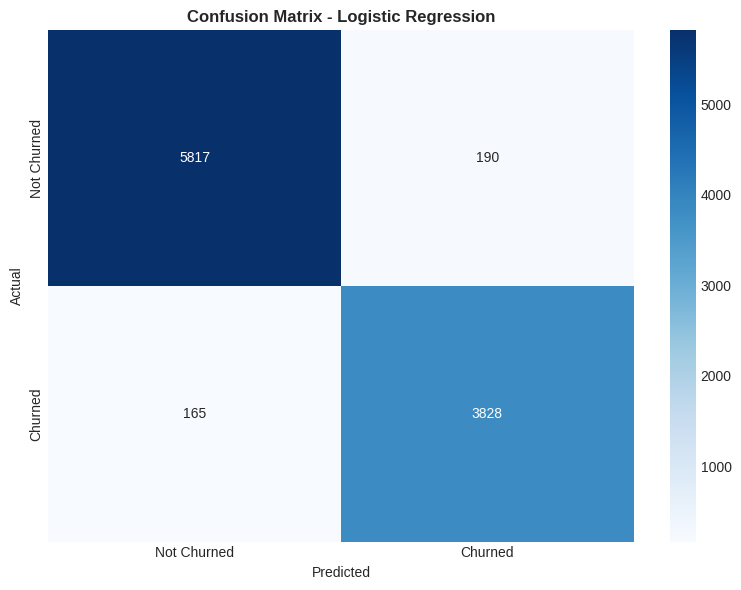

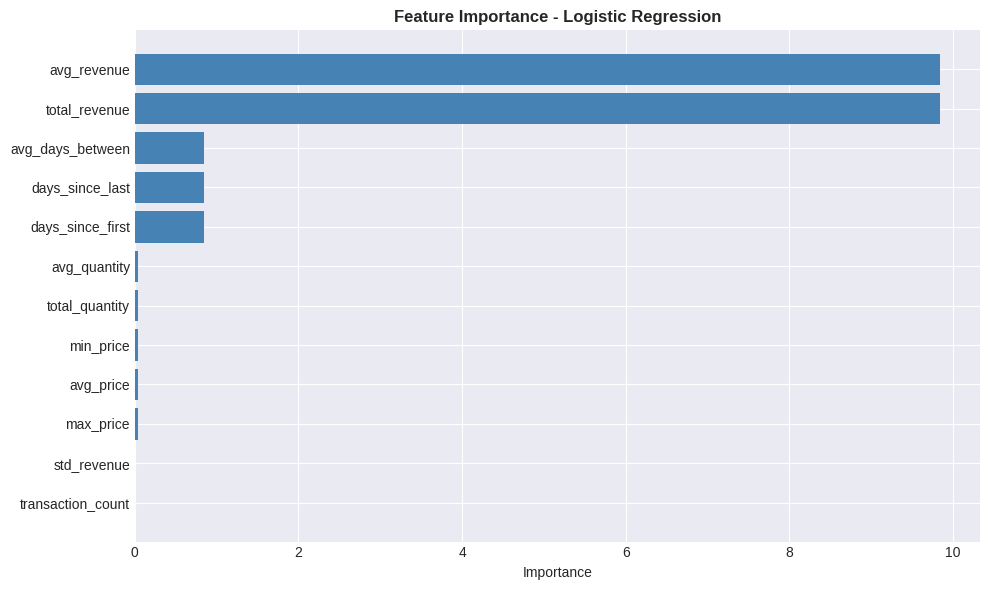


Best parameters: {'C': 10.0, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


In [10]:
with mlflow.start_run(run_name="LogisticRegression_baseline"):
    # Hyperparameter grid
    param_grid = {
        'C': [0.01, 0.1, 1.0, 10.0],
        'penalty': ['l2'],
        'solver': ['lbfgs'],
        'max_iter': [1000]
    }
    
    # Grid search
    lr = LogisticRegression(random_state=42)
    grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    
    best_lr = grid_search.best_estimator_
    
    # Evaluate
    lr_metrics, lr_pred, lr_prob = evaluate_model(best_lr, X_val_scaled, y_val, "Logistic Regression")
    
    # Log to MLflow
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metrics(lr_metrics)
    mlflow.sklearn.log_model(best_lr, "model")
    
    # Save and log artifacts
    plot_confusion_matrix(y_val, lr_pred, "Logistic Regression", "lr_confusion_matrix.png")
    plot_feature_importance(best_lr, feature_cols, "Logistic Regression", "lr_feature_importance.png")
    mlflow.log_artifact("lr_confusion_matrix.png")
    mlflow.log_artifact("lr_feature_importance.png")
    
    print(f"\nBest parameters: {grid_search.best_params_}")
    lr_run_id = mlflow.active_run().info.run_id

## 8. XGBoost Classifier

/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:53:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:53:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:53:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:53:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, ite

/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:53:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:53:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:53:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:53:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:53:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:53:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:53:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:53:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:53:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:53:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:53:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:53:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:53:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:53:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:53:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:53:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:53:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:53:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:53:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:53:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/onlyahad/miniconda3/envs/ml_global/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [16:54:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


2025/12/15 16:54:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



XGBoost Results
ACCURACY        0.9990
PRECISION       0.9990
RECALL          0.9985
F1              0.9987
AUC_ROC         1.0000


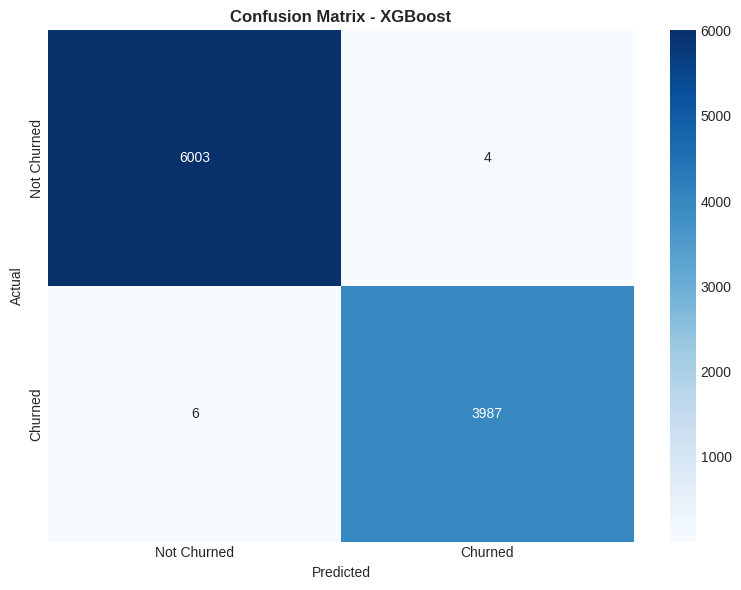

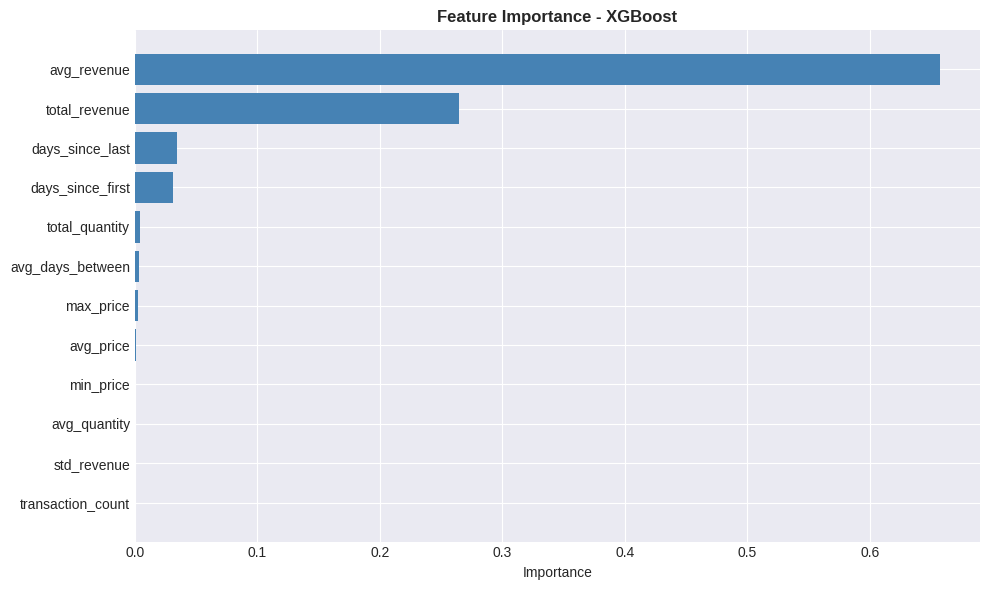


Best parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


In [11]:
with mlflow.start_run(run_name="XGBoost_tuned"):
    # Hyperparameter grid
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    
    # Randomized search (faster than grid search)
    xgb_clf = xgb.XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    )
    
    random_search = RandomizedSearchCV(
        xgb_clf, param_grid, n_iter=20, cv=5,
        scoring='roc_auc', n_jobs=-1, random_state=42
    )
    random_search.fit(X_train, y_train)
    
    best_xgb = random_search.best_estimator_
    
    # Evaluate
    xgb_metrics, xgb_pred, xgb_prob = evaluate_model(best_xgb, X_val, y_val, "XGBoost")
    
    # Log to MLflow
    mlflow.log_params(random_search.best_params_)
    mlflow.log_metrics(xgb_metrics)
    mlflow.xgboost.log_model(best_xgb, "model")
    
    # Save and log artifacts
    plot_confusion_matrix(y_val, xgb_pred, "XGBoost", "xgb_confusion_matrix.png")
    plot_feature_importance(best_xgb, feature_cols, "XGBoost", "xgb_feature_importance.png")
    mlflow.log_artifact("xgb_confusion_matrix.png")
    mlflow.log_artifact("xgb_feature_importance.png")
    
    print(f"\nBest parameters: {random_search.best_params_}")
    xgb_run_id = mlflow.active_run().info.run_id

## 9. LightGBM Classifier

2025/12/15 16:55:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



LightGBM Results
ACCURACY        0.9988
PRECISION       0.9977
RECALL          0.9992
F1              0.9985
AUC_ROC         1.0000


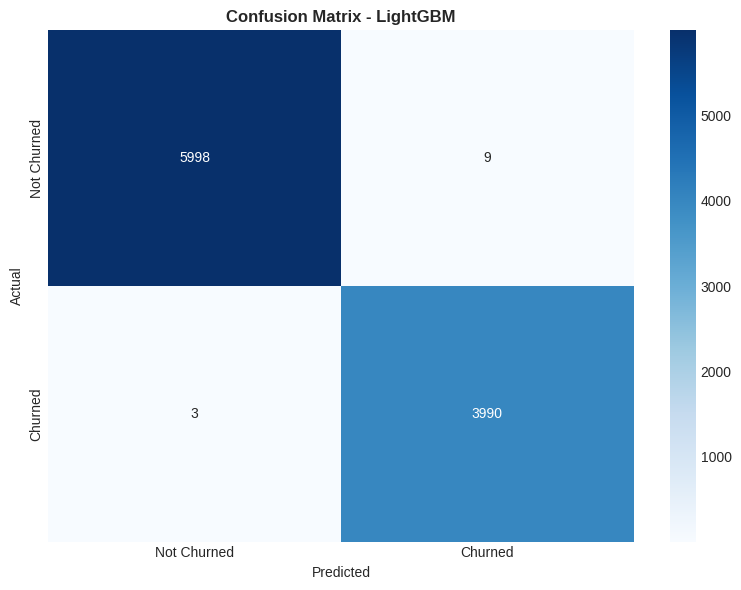

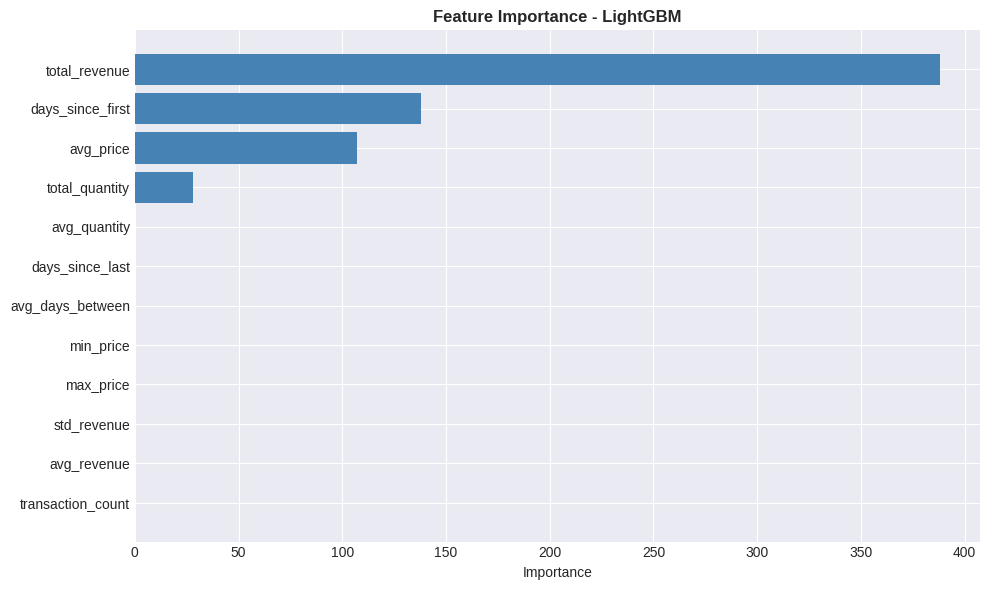


Best parameters: {'subsample': 1.0, 'num_leaves': 31, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}


In [12]:
with mlflow.start_run(run_name="LightGBM_tuned"):
    # Hyperparameter grid
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7, -1],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [31, 50, 100],
        'subsample': [0.8, 1.0]
    }
    
    lgb_clf = lgb.LGBMClassifier(random_state=42, verbose=-1)
    
    random_search = RandomizedSearchCV(
        lgb_clf, param_grid, n_iter=20, cv=5,
        scoring='roc_auc', n_jobs=-1, random_state=42
    )
    random_search.fit(X_train, y_train)
    
    best_lgb = random_search.best_estimator_
    
    # Evaluate
    lgb_metrics, lgb_pred, lgb_prob = evaluate_model(best_lgb, X_val, y_val, "LightGBM")
    
    # Log to MLflow
    mlflow.log_params(random_search.best_params_)
    mlflow.log_metrics(lgb_metrics)
    mlflow.lightgbm.log_model(best_lgb, "model")
    
    # Save and log artifacts
    plot_confusion_matrix(y_val, lgb_pred, "LightGBM", "lgb_confusion_matrix.png")
    plot_feature_importance(best_lgb, feature_cols, "LightGBM", "lgb_feature_importance.png")
    mlflow.log_artifact("lgb_confusion_matrix.png")
    mlflow.log_artifact("lgb_feature_importance.png")
    
    print(f"\nBest parameters: {random_search.best_params_}")
    lgb_run_id = mlflow.active_run().info.run_id

## 10. Model Comparison

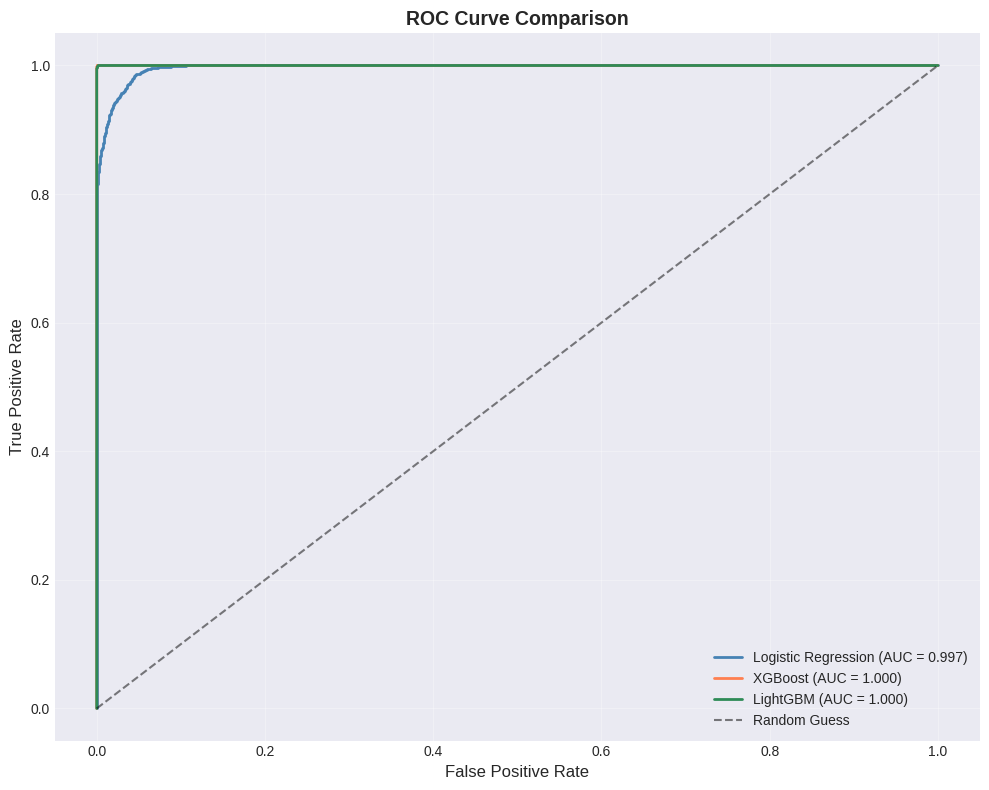

In [13]:
# Compare ROC curves
fig, ax = plt.subplots(figsize=(10, 8))

models = [
    ('Logistic Regression', lr_prob, 'steelblue'),
    ('XGBoost', xgb_prob, 'coral'),
    ('LightGBM', lgb_prob, 'seagreen')
]

for name, probs, color in models:
    fpr, tpr, _ = roc_curve(y_val, probs)
    auc = roc_auc_score(y_val, probs)
    ax.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', color=color, linewidth=2)

ax.plot([0, 1], [0, 1], 'k--', label='Random Guess', alpha=0.5)
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('roc_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [14]:
# Summary table
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'XGBoost', 'LightGBM'],
    'Accuracy': [lr_metrics['accuracy'], xgb_metrics['accuracy'], lgb_metrics['accuracy']],
    'Precision': [lr_metrics['precision'], xgb_metrics['precision'], lgb_metrics['precision']],
    'Recall': [lr_metrics['recall'], xgb_metrics['recall'], lgb_metrics['recall']],
    'F1 Score': [lr_metrics['f1'], xgb_metrics['f1'], lgb_metrics['f1']],
    'AUC-ROC': [lr_metrics['auc_roc'], xgb_metrics['auc_roc'], lgb_metrics['auc_roc']]
}).round(4)

print("\nModel Comparison Summary:")
print("=" * 80)
print(comparison_df.to_string(index=False))


Model Comparison Summary:
              Model  Accuracy  Precision  Recall  F1 Score  AUC-ROC
Logistic Regression    0.9645     0.9527  0.9587    0.9557   0.9965
            XGBoost    0.9990     0.9990  0.9985    0.9987   1.0000
           LightGBM    0.9988     0.9977  0.9992    0.9985   1.0000


## 11. Generate Model Card

In [15]:
def generate_model_card(
    model_name: str,
    metrics: dict,
    best_params: dict,
    feature_names: list,
    train_size: int,
    val_size: int,
    churn_rate: float,
    output_path: str
):
    """Generate a model card markdown file."""
    
    template = f"""# Model Card: {model_name}

## Model Details

| Field | Value |
|-------|-------|
| Model Name | {model_name} |
| Version | 1.0.0 |
| Date | {datetime.now().strftime('%Y-%m-%d')} |
| Task | Binary Classification (Churn Prediction) |
| Framework | scikit-learn / XGBoost / LightGBM |

## Dataset Statistics

| Metric | Value |
|--------|-------|
| Training Samples | {train_size:,} |
| Validation Samples | {val_size:,} |
| Churn Rate | {churn_rate:.2%} |
| Features | {len(feature_names)} |

### Features Used

{chr(10).join(['- ' + f for f in feature_names])}

## Hyperparameters

```json
{json.dumps(best_params, indent=2)}
```

## Performance Metrics

| Metric | Score |
|--------|-------|
| Accuracy | {metrics['accuracy']:.4f} |
| Precision | {metrics['precision']:.4f} |
| Recall | {metrics['recall']:.4f} |
| F1 Score | {metrics['f1']:.4f} |
| AUC-ROC | {metrics['auc_roc']:.4f} |

## Intended Use

This model is intended to predict customer churn based on transaction behavior.
Use cases include:
- Identifying at-risk customers for retention campaigns
- Prioritizing customer success outreach
- Informing loyalty program targeting

## Limitations

- Trained on synthetic business events data
- Churn definition (7-day inactivity) may not align with all business contexts
- Performance may degrade with distribution shift over time
- Should be retrained periodically with fresh data

## Ethical Considerations

- Model predictions should not be the sole basis for consequential decisions
- Human review recommended for high-impact interventions
- Ensure fair treatment across customer segments

## MLflow Tracking

Experiment: `churn-classification-baselines`

---
*Generated automatically by `02_baselines.ipynb`*
"""
    
    with open(output_path, 'w') as f:
        f.write(template)
    
    print(f"Model card saved to: {output_path}")


# Find best model
best_model_metrics = max(
    [('Logistic Regression', lr_metrics, grid_search.best_params_),
     ('XGBoost', xgb_metrics, random_search.best_params_),
     ('LightGBM', lgb_metrics, random_search.best_params_)],
    key=lambda x: x[1]['auc_roc']
)

# Generate model card for best model
generate_model_card(
    model_name=best_model_metrics[0],
    metrics=best_model_metrics[1],
    best_params=best_model_metrics[2],
    feature_names=feature_cols,
    train_size=len(X_train),
    val_size=len(X_val),
    churn_rate=y.mean(),
    output_path='model_card.md'
)

Model card saved to: model_card.md


## 12. Summary

### Key Results
- Trained 3 baseline models: Logistic Regression, XGBoost, and LightGBM
- All experiments logged to MLflow for reproducibility
- Generated automated model card for documentation

### Next Steps
- Feature engineering improvements (e.g., time-based features, RFM segmentation)
- Ensemble methods or stacking
- Threshold optimization for business objectives
- Production deployment via FastAPI

In [16]:
print(f"\nNotebook execution complete at: {datetime.now().isoformat()}")
print(f"\nMLflow runs:")
print(f"  - Logistic Regression: {lr_run_id}")
print(f"  - XGBoost: {xgb_run_id}")
print(f"  - LightGBM: {lgb_run_id}")
print(f"\nView experiments with: mlflow ui --backend-store-uri {MLFLOW_TRACKING_URI}")


Notebook execution complete at: 2025-12-15T16:55:34.355804

MLflow runs:
  - Logistic Regression: cbfef0d12dbc4b7585054fe099c71db0
  - XGBoost: 665e8259959945f6982d495d0e378188
  - LightGBM: 0729ccfe9acf4c75971fb45b342c914f

View experiments with: mlflow ui --backend-store-uri /home/onlyahad/Desktop/Flagship Project/mlruns
